## Stage subset of Russia shp files without clipping to fp fix and with clipping to fp fix in local viz-staging

- 3 ice wedge polygon files from [Wrangle Island](https://www.google.com/maps/place/Wrangel+Island/@71.3497058,179.8238705,9z/data=!4m6!3m5!1s0x50a70636a5f5033f:0xe1dca925085b4bc3!8m2!3d71.2488724!4d-179.9789208!16zL20vMDMyZnRq), off the coasts of Russia & Alaska
- bug fix branch of viz-staging, first create staged tiles without fix to visualize in local cesium
- then, using same branch, make changes and create tiles again and visualize again and see if it looks different
- using conda env `clipToFP_PR`
- after running through these steps in chunks in this notebook, it's a great idea to transfer the code to a script and run as a `tmux` session

In [1]:
# input data import
from pathlib import Path

# staging
import pdgstaging
from pdgstaging import TileStager

# rasterization
import pdgraster
from pdgraster import RasterTiler

# visual checks
import geopandas as gpd

# logging
from datetime import datetime
import logging
import logging.handlers
import os

In [2]:
base_dir = Path('/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp')
filename = '*.shp'
# To define each .shp file within each subdir as a string representation with forward slashes, use as_posix()
# The ** represents that any subdir string can be present between the base_dir and the filename
input_3files = [p.as_posix() for p in base_dir.glob('**/' + filename)]
input_3files

['/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/WV02_20100720235408_1030010006ABA200_10JUL20235408-M1BS-500152191020_01_P002_u16rf3413_pansh/WV02_20100720235408_1030010006ABA200_10JUL20235408-M1BS-500152191020_01_P002_u16rf3413_pansh.shp',
 '/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/WV02_20100720235424_1030010006263400_10JUL20235424-M1BS-500226255100_01_P002_u16rf3413_pansh/WV02_20100720235424_1030010006263400_10JUL20235424-M1BS-500226255100_01_P002_u16rf3413_pansh.shp',
 '/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh.shp']

In [3]:
# subset the input to just 2 adjacent files
input = input_3files[1:3]
input

['/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/WV02_20100720235424_1030010006263400_10JUL20235424-M1BS-500226255100_01_P002_u16rf3413_pansh/WV02_20100720235424_1030010006263400_10JUL20235424-M1BS-500226255100_01_P002_u16rf3413_pansh.shp',
 '/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh.shp']

### Define the logging configuration

This prints logging statements to a file specified by the path in the config. Change the filepath as needed.

In [4]:
handler = logging.handlers.WatchedFileHandler(
    os.environ.get("LOGFILE", "/home/jcohen/viz-staging/log_no_fix_yet.log"))
formatter = logging.Formatter(logging.BASIC_FORMAT)
handler.setFormatter(formatter)
root = logging.getLogger()
root.setLevel(os.environ.get("LOGLEVEL", "INFO"))
root.addHandler(handler)

#### Plot the file we will stage first

In [9]:
# pull filepaths for footprints in the same way we pulled IWP shp file paths
base_dir_fp = Path('/home/jcohen/iwp_russia_subset_clipToFP_PR/footprints')
# To define each .shp file within each subdir as a string representation with forward slashes, use as_posix()
# The ** represents that any subdir string can be present between the base_dir and the filename
fps = [p.as_posix() for p in base_dir_fp.glob('**/' + filename)]
fps[2]

'/home/jcohen/iwp_russia_subset_clipToFP_PR/footprints/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh/WV02_20100720235425_1030010006263400_10JUL20235425-M1BS-500226255100_01_P003_u16rf3413_pansh.shp'

<Axes: >

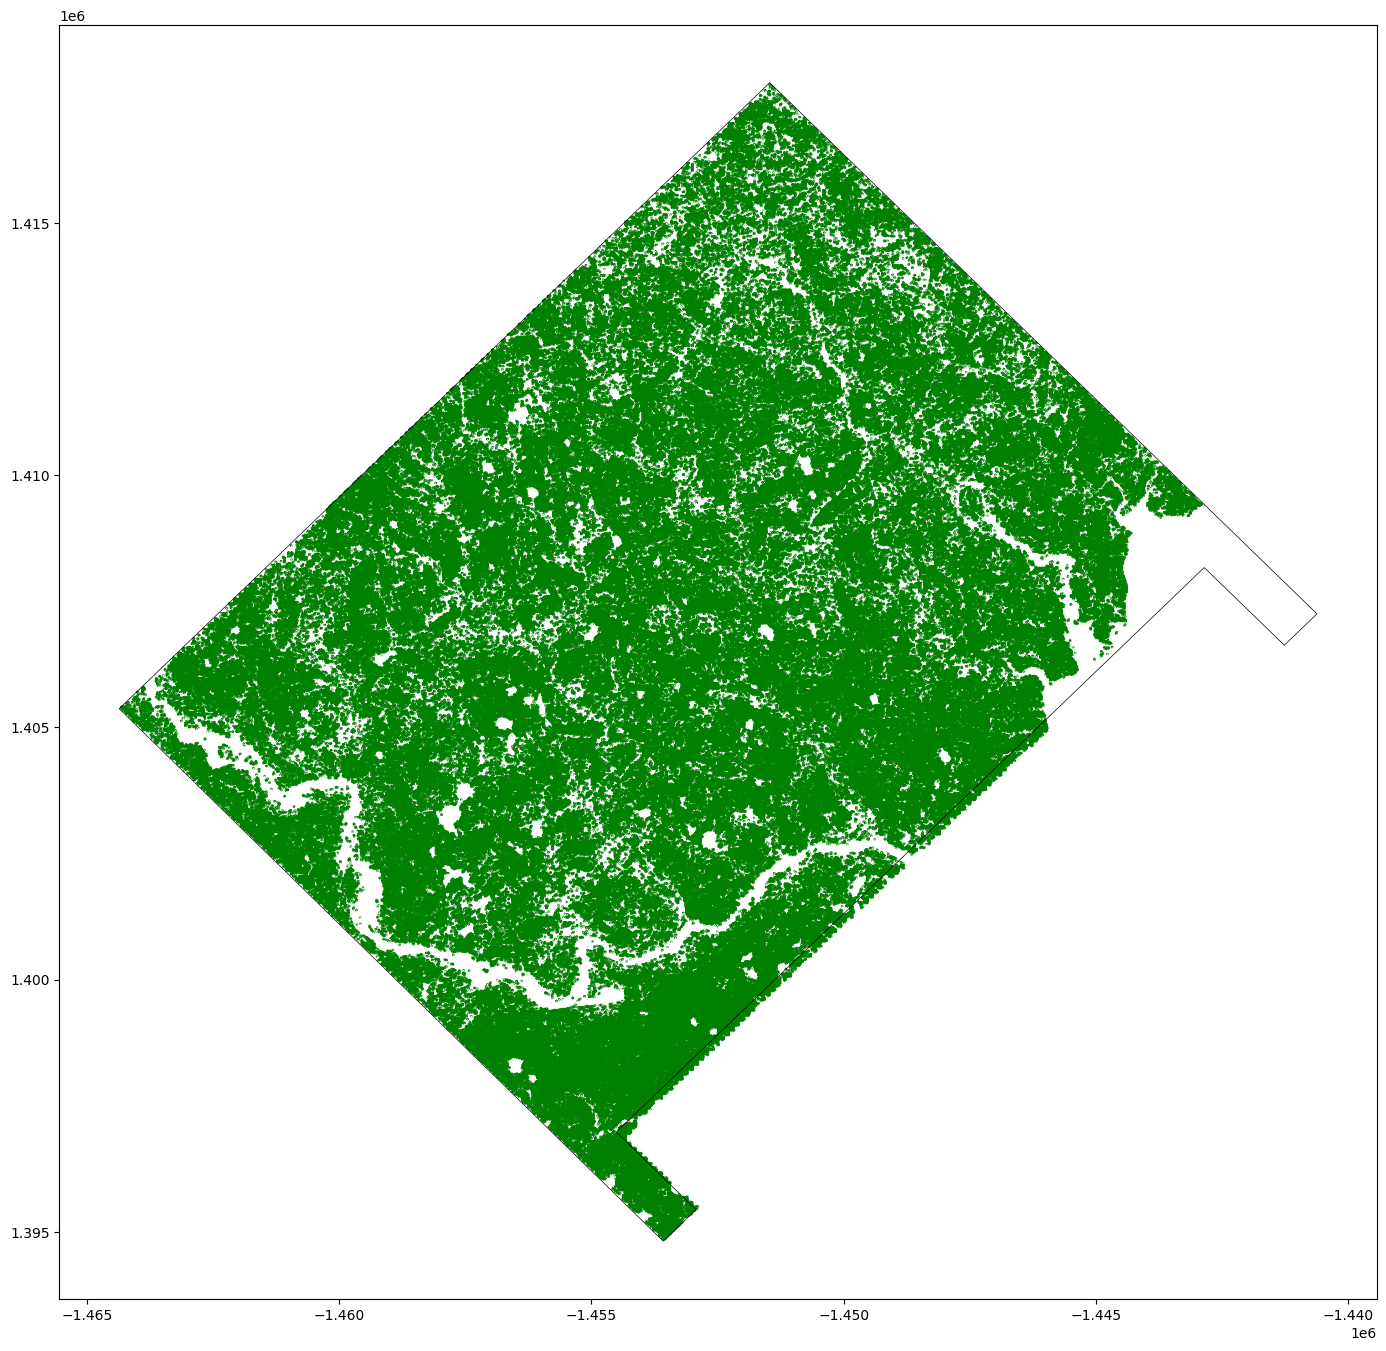

In [10]:
# the iwp file with polygons that hang over the edge of the footprint by a lot
shp = gpd.read_file(input[1])
footprint = gpd.read_file(fps[2])
ax = shp.plot(color='none', edgecolor='green', linewidths=1.5, figsize=(17,17))
footprint.plot(ax=ax, color='none', edgecolor='black', linewidths=0.5, figsize=(17,17))

### Define the stager

You can input the config directly to `TileStager()`, or save the config as an object earlier in the script, or save the config as a separate `.py` or `.json` script and source it in with:
```python
# config.py must be a script in same level of folder hierachy as this notebook 
# that contains config defined as an object like `config = {...}` 
import config 
config = config.config
pdgstaging.TileStager(config)
```


In [11]:
stager = TileStager({
  "deduplicate_clip_to_footprint": True, 
  "dir_input": "/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/", 
  "ext_input": ".shp",
  "ext_footprints": ".shp",
  "dir_footprints": "/home/jcohen/iwp_russia_subset_clipToFP_PR/footprints/", 
  "dir_staged": "staged/",
  "dir_geotiff": "geotiff/", 
  "dir_web_tiles": "web_tiles/", 
  "filename_staging_summary": "staging_summary.csv",
  "filename_rasterization_events": "raster_events.csv",
  "filename_rasters_summary": "raster_summary.csv",
  "filename_config": "config",
  "simplify_tolerance": 0.1,
  "tms_id": "WGS1984Quad",
  "z_range": [
    0,
    15
  ],
  "geometricError": 57,
  "z_coord": 0,
  "statistics": [
    {
      "name": "iwp_coverage",
      "weight_by": "area",
      "property": "area_per_pixel_area",
      "aggregation_method": "sum",
      "resampling_method": "average",
      "val_range": [
        0,
        1
      ],
      "palette": [
        "#66339952",
        "#ffcc00"
      ],
      "nodata_val": 0,
      "nodata_color": "#ffffff00"
    },
  ],
  "deduplicate_at": [
    "raster"
  ],
  "deduplicate_keep_rules": [
    [
      "Date",
      "larger"
    ]
  ],
  "deduplicate_method": "footprints"
})

In [12]:
# fist stage the file with polygons hanging over the edge of the footprint 
# this is necessary in order for the clipping to fp to NOT work
stager.stage(input[1])

That file produced 2,055 staged files.

In [14]:
# then stage the other file, the one with polygons that barely hang over the edge of the footprint
stager.stage(input[0])

That file produced 370 staged files (it has fewer ice wedge polygons detected). Together, these files produced 2,425 staged files.

## Rasterization & Web-tiling

- Use the `pdgraster.RasterTiler()` function to create the `rasterizer`, then use it to execute the rasterize function: `rasterizer.rasterize_vectors()`.
- Alternatively, can run these two steps as one with just `pdgraster.RasterTiler().rasterize_all()`. Just as in staging, you can input the config directly to `RasterTiler()`, or save the config as an object earlier in the script, or save the config as a separate script and source it in. 
- `rasterize_all()` is a wrapper for `rasterize_vectors()`. It pulls all staged filepaths from the staged dir and rasterizes all z-levels . We do _not_ use `rasterize_all()` when rasterizing in parallel with `parsl` or `ray`. It is exclusively used for small datasets that are not run in parallel. We have to create specific `@parsl` or `@ray.remote` wrapper functions around `stage()` and `rasterize_vectors()` if using those packages for staging, rasterizaiton, etc. For an example, see [here](https://github.com/PermafrostDiscoveryGateway/viz-workflow/blob/8c1997a9d2456bcb79ba1b3ab0f82b3b2b30b141/IN_PROGRESS_VIZ_WORKFLOW.py#L668-L693) for how we rasterize in the ray workflow.
- Rasterization when executed with `rasterize_all()` creates `.tif` files in the output `geotiff` dir, _and_ creates the same number of `.png` files in the output `web_tiles` dir.
    - When we use `rasterize_vectors()` instead, we _only create the `.tif` files and not the `.png` files_. So that needs to be executed as a separate step with `rasterizer.webtiles_from_geotiffs()` after the `rasterize_vectors() step`, and _in between those steps_ we need to manually "update the ranges" in the rasterizer to ensure that the colors within one z-level of `.png` files looks appropriate when visualized in the portal. We will cross that bridge as necessay, just as we do [here](https://github.com/PermafrostDiscoveryGateway/viz-workflow/blob/8c1997a9d2456bcb79ba1b3ab0f82b3b2b30b141/IN_PROGRESS_VIZ_WORKFLOW.py#L592) in the `ray` workflow on Delta.
- The number of z-level 15 tiles in the `staged` dir should match the number of z-level 15 tiles in the `geotiff` and `web_tiles` dirs. The total number of files in both the `geotiff` and `web_tiles` dirs is a _lot_ more than the number of files in `staged` because `staged` _only contains the highest zoom level_ with no parent z-levels.
- The web tiles are what we actually visualize on the PDG portal and local cesium. We create the rasters for summary stats (the data behind the web tiles, stored in bands of the `.tif` files)




In [15]:
RasterTiler({
  "deduplicate_clip_to_footprint": True, 
  "dir_input": "/home/jcohen/iwp_russia_subset_clipToFP_PR/iwp/", 
  "ext_input": ".shp",
  "ext_footprints": ".shp",
  "dir_footprints": "/home/jcohen/iwp_russia_subset_clipToFP_PR/footprints/", 
  "dir_staged": "staged/",
  "dir_geotiff": "geotiff/", 
  "dir_web_tiles": "web_tiles/", 
  "filename_staging_summary": "staging_summary.csv",
  "filename_rasterization_events": "raster_events.csv",
  "filename_rasters_summary": "raster_summary.csv",
  "filename_config": "config",
  "simplify_tolerance": 0.1,
  "tms_id": "WGS1984Quad",
  "z_range": [
    0,
    15
  ],
  "geometricError": 57,
  "z_coord": 0,
  "statistics": [
    {
      "name": "iwp_coverage",
      "weight_by": "area",
      "property": "area_per_pixel_area",
      "aggregation_method": "sum",
      "resampling_method": "average",
      "val_range": [
        0,
        1
      ],
      "palette": [
        "#66339952",
        "#ffcc00"
      ],
      "nodata_val": 0,
      "nodata_color": "#ffffff00"
    },
  ],
  "deduplicate_at": [
    "raster"
  ],
  "deduplicate_keep_rules": [
    [
      "Date",
      "larger"
    ]
  ],
  "deduplicate_method": "footprints"
}).rasterize_all()

Number of `geotiff` files produced (for all z-levels): **3318**

Number of `web_tiles` produced (for all z-levels): **3318**